In [2]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

# Deep learning library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 2: Load dataset
df = pd.read_csv("dataset/customer_purchase_data.csv")

# ===== Optional Feature Engineering =====

# 1. Age group 
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[17, 30, 50, 70],  
    labels=[0, 1, 2]
)

# 2. Income level 
df["IncomeLevel"] = pd.qcut(
    df["AnnualIncome"],
    q=3,
    labels=[0, 1, 2]
)

# 3. Engagement score
df["EngagementScore"] = df["NumberOfPurchases"] * df["TimeSpentOnWebsite"]

# 4. Discount usage rate
df["DiscountRate"] = df["DiscountsAvailed"] / (df["NumberOfPurchases"] + 1)

# Display first 5 rows
df.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus,AgeGroup,IncomeLevel,EngagementScore,DiscountRate
0,40,1,66120.267939,8,0,30.568601,0,5,1,1,1,244.548809,0.555556
1,20,1,23579.773583,4,2,38.240097,0,5,0,0,0,152.960386,1.000000
2,27,1,127821.306432,11,2,31.633212,1,0,1,0,2,347.965327,0.000000
3,24,1,137798.623120,19,3,46.167059,0,4,1,0,2,877.174117,0.200000
4,31,1,99300.964220,19,1,19.823592,0,0,1,1,1,376.648245,0.000000


In [3]:
# Step 3: Data preprocessing

# Check missing values
print(df.isnull().sum())

# Separate features (X) and target (y)
X = df.drop("PurchaseStatus", axis=1)
y = df["PurchaseStatus"]

# Split train-test data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Age                   0
Gender                0
AnnualIncome          0
NumberOfPurchases     0
ProductCategory       0
TimeSpentOnWebsite    0
LoyaltyProgram        0
DiscountsAvailed      0
PurchaseStatus        0
AgeGroup              0
IncomeLevel           0
EngagementScore       0
DiscountRate          0
dtype: int64


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8191666666666666

Test Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88       172
           1       0.90      0.73      0.81       128

    accuracy                           0.85       300
   macro avg       0.86      0.84      0.84       300
weighted avg       0.86      0.85      0.85       300



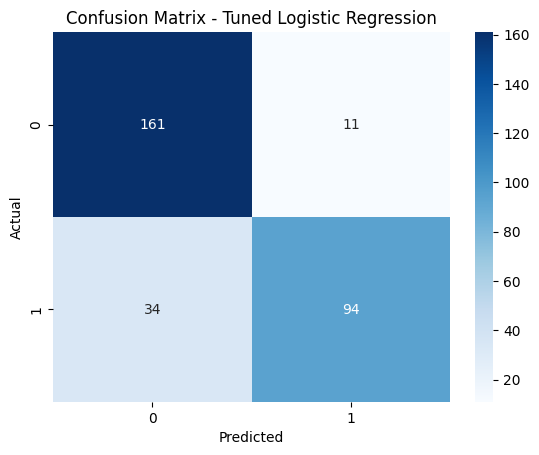

In [4]:
# Step 4: Logistic Regression model with Hyperparameter Tuning
# Define parameter grid to search different combinations
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'penalty': ['l1', 'l2'],            # Type of regularization
    'solver': ['liblinear', 'saga']     # Optimization algorithm
}

# Create the Logistic Regression model
log_model = LogisticRegression(max_iter=1000)

# GridSearchCV automatically tests every parameter combination with cross-validation
grid_search = GridSearchCV(
    estimator=log_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,                 # 5-fold cross-validation
    verbose=1,
    n_jobs=-1             # Use all CPU cores
)

# Fit model to training data (tuning happens here)
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_log_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Predict using the best model
y_pred_log = best_log_model.predict(X_test)

# Evaluate
print("\nTest Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Reloading Tuner from tuner_results\DNN_tuning\tuner0.json
Best Hyperparameters found:
Number of layers: 1
Units per layer: [56]
Learning rate: 0.01
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7958 - loss: 0.4478 - val_accuracy: 0.8125 - val_loss: 0.4066
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8458 - loss: 0.3888 - val_accuracy: 0.7958 - val_loss: 0.4273
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.3789 - val_accuracy: 0.8000 - val_loss: 0.4209
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.3684 - val_accuracy: 0.8000 - val_loss: 0.4354
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8708 - loss: 0.3604 - val_accuracy: 0.8042 - val_loss: 0.4245
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 0.3546 - val_accuracy: 0.8167 - val_loss: 0.4223
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8719 - loss: 0.3529 - val_accura

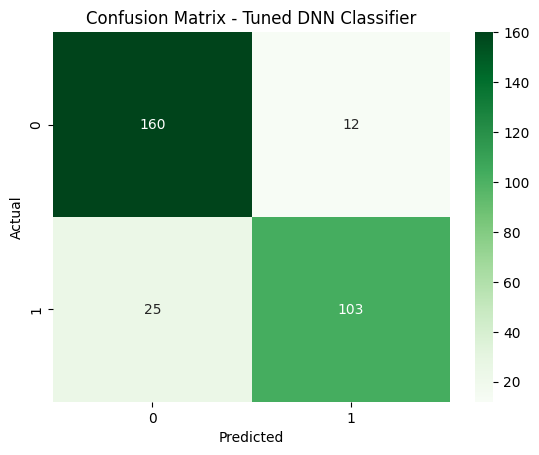

In [5]:
# Step 5: DNN Classifier with Hyperparameter Tuning
# Define a function that builds the model (for tuning)
def build_model(hp):
    model = Sequential()
    # Tune the number of hidden layers (1 to 3)
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tune the number of neurons per layer (8 to 64, step=8)
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=8, max_value=64, step=8),
                        activation='relu'))
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create a RandomSearch tuner to find the best combination of hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',     # Optimization goal: maximize validation accuracy
    max_trials=10,                # Number of different hyperparameter combinations to test
    executions_per_trial=1,       # Each trial will be executed once
    directory='tuner_results',    # Folder to save tuning results
    project_name='DNN_tuning'     # Subfolder for this project
)

# Run the hyperparameter search process
tuner.search(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

# Retrieve the best hyperparameters from the search
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters found:")
print("Number of layers:", best_hp.get('num_layers'))
print("Units per layer:", [best_hp.get('units_' + str(i)) for i in range(best_hp.get('num_layers'))])
print("Learning rate:", best_hp.get('learning_rate'))

# Rebuild and train the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hp)
history_best = best_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Step 6: Evaluate the tuned DNN Classifier
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\nBest DNN Classifier Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred_dnn = (best_model.predict(X_test) > 0.5).astype("int32")

# Display classification performance
print("\nClassification Report:\n", classification_report(y_test, y_pred_dnn))

# Display confusion matrix
cm_dnn = confusion_matrix(y_test, y_pred_dnn)
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Tuned DNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

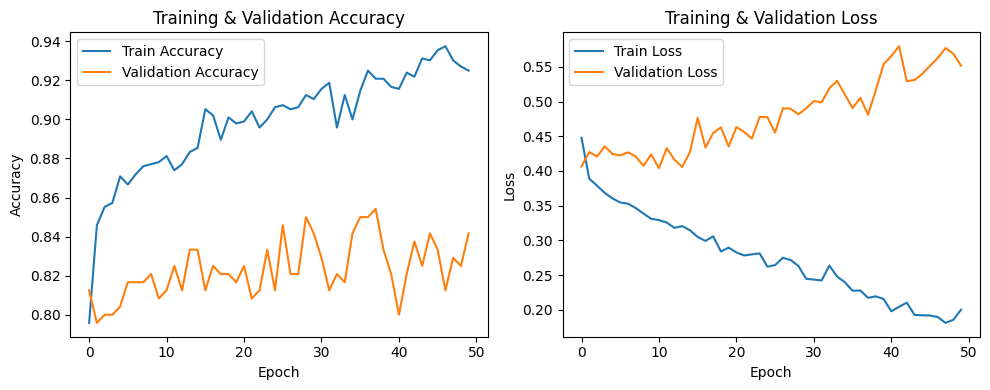

In [8]:
# Step 7: Plot training accuracy and loss for the best DNN model
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_best.history['accuracy'], label='Train Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

# ==========================================================
# Step 8: Logistic Regression vs DNN – Performance Comparison
# ==========================================================

# 1. Compute metrics for tuned Logistic Regression
log_acc  = accuracy_score(y_test, y_pred_log)
log_prec = precision_score(y_test, y_pred_log)
log_rec  = recall_score(y_test, y_pred_log)
log_f1   = f1_score(y_test, y_pred_log)

# 2. Compute metrics for tuned DNN Classifier
dnn_acc  = accuracy_score(y_test, y_pred_dnn)
dnn_prec = precision_score(y_test, y_pred_dnn)
dnn_rec  = recall_score(y_test, y_pred_dnn)
dnn_f1   = f1_score(y_test, y_pred_dnn)

# 3. Put everything into a comparison table (similar to regression)
results_cls = pd.DataFrame({
    "Model":     ["Tuned Logistic Regression", "Tuned DNN Classifier"],
    "Accuracy":  [log_acc,  dnn_acc],
    "Precision": [log_prec, dnn_prec],
    "Recall":    [log_rec,  dnn_rec],
    "F1-score":  [log_f1,   dnn_f1]
})

print("\n📊 Classification Model Performance Comparison:")
display(
    results_cls
        .style.background_gradient(cmap="YlGnBu")
        .format("{:.3f}", subset=["Accuracy", "Precision", "Recall", "F1-score"])
)


📊 Classification Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-score
0,Tuned Logistic Regression,0.850,0.895,0.734,0.807
1,Tuned DNN Classifier,0.877,0.896,0.805,0.848
